In [516]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm 
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import scipy as sc
from scipy.spatial.distance import cdist 
from sklearn.cluster import KMeans
from scipy.spatial import distance
import sklearn
from sklearn.metrics import silhouette_score
from sklearn import metrics
import qwikidata
import qwikidata.sparql
import json
from numpy.random import uniform
from sklearn.datasets import make_blobs
import seaborn as sns
import random
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.decomposition import PCA


In [517]:
data=pd.read_csv('bank_transactions.csv')

In [518]:
data.head(5)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


$$EXPLORATORY ANALYSIS$$

In [519]:
data.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [520]:
#Let's understand the distribution of our missing data
missing_data=pd.DataFrame({'NaN_Counts': data.isna().sum(), 'NaN_Proportions(%)': (data.isna().sum() / data.shape[0]) * 100}).sort_values(by='NaN_Counts', ascending=False)
missing_data = missing_data.drop(['TransactionID','CustomerID','TransactionDate','TransactionTime','TransactionAmount (INR)'])
missing_data

,NaN_Counts,NaN_Proportions(%)
CustomerDOB,3397,0.323966
CustAccountBalance,2369,0.225927
CustGender,1100,0.104905
CustLocation,151,0.014401


In [521]:
df = pd.DataFrame(
    {
        "features": ["CustomerDOB", "CustAccountBalance", "CustGender", "CustLocation"],
        "NaN_Counts": [3397, 2369, 1100, 151],
        "NaN_Proportions(%)": [0.323966,0.225927 ,0.104905 ,0.014401 ],
    }
)

Text(0.5, 1.0, 'MISSING VALUES DISTRIBUTION (by columns)')

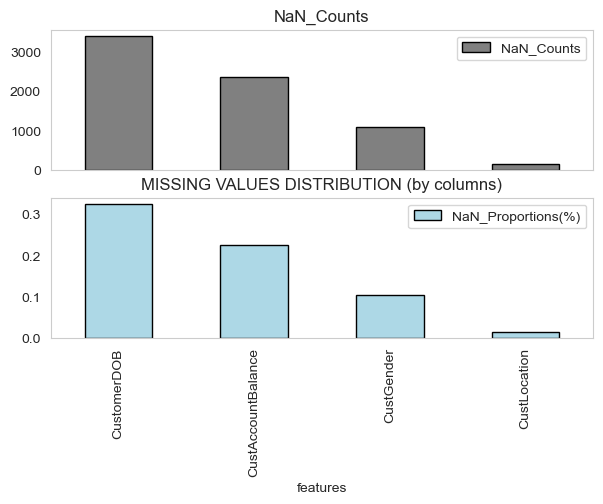

In [522]:
df.plot.bar(x="features", subplots=True,color=['gray','lightblue'],edgecolor='black')
plt.title('MISSING VALUES DISTRIBUTION (by columns)')

In [523]:
data.dropna(inplace=True)

In [524]:
data.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [525]:
data.describe() #quick summary of our data

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,1.041614e+06,1.041614e+06,1.041614e+06
mean,1.149986e+05,1.571221e+05,1.566096e+03
std,8.467609e+05,5.126352e+04,6.561464e+03
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.728140e+03,1.240410e+05,1.600000e+02
50%,1.676852e+04,1.642470e+05,4.575000e+02
75%,5.742885e+04,2.000220e+05,1.200000e+03
max,1.150355e+08,2.359590e+05,1.560035e+06


In [526]:
data.info() #we can observe that transaction date and DOB are in object format, let's covert those in time format 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041614 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1041614 non-null  object 
 1   CustomerID               1041614 non-null  object 
 2   CustomerDOB              1041614 non-null  object 
 3   CustGender               1041614 non-null  object 
 4   CustLocation             1041614 non-null  object 
 5   CustAccountBalance       1041614 non-null  float64
 6   TransactionDate          1041614 non-null  object 
 7   TransactionTime          1041614 non-null  int64  
 8   TransactionAmount (INR)  1041614 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 79.5+ MB


In [527]:
data.CustomerDOB=pd.to_datetime(data.CustomerDOB)

In [528]:
data.TransactionDate=pd.to_datetime(data.TransactionDate)

In [529]:
data.TransactionTime = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

In [530]:
data.CustomerDOB.dt.year.value_counts()

1990    72616
1991    71185
1989    69156
1992    66484
1988    62905
        ...  
2020        2
2011        2
2016        2
2025        1
2018        1
Name: CustomerDOB, Length: 100, dtype: int64

In [531]:
#let's check the format of transaction date
data.TransactionTime.max() 
#probably this is hours/minutes/seconds

Timestamp('1900-01-01 23:59:59')

<AxesSubplot:>

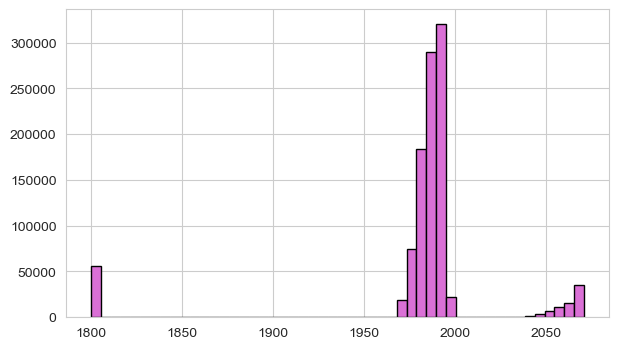

In [532]:
 #visualize with an histogram the distribution of customers d.o.b.
data.CustomerDOB.dt.year.hist(bins=50,color='orchid',edgecolor='black')
#that's something strange. Probably this is a millenium bug after year 2000

In [533]:
#We can try to those customers born in 1800(that's really strange)
data.drop(data[data.CustomerDOB.dt.year==1800].index,axis=0,inplace=True)

In [534]:
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

<AxesSubplot:>

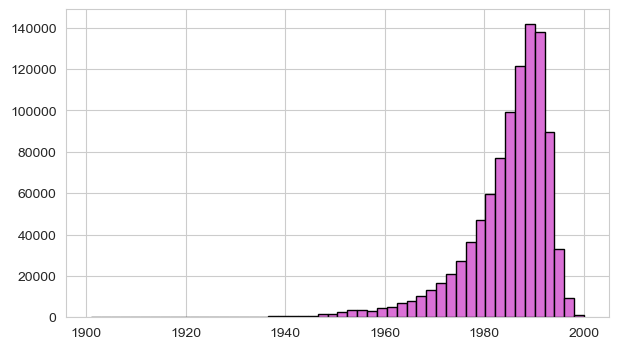

In [535]:
data.CustomerDOB.dt.year.hist(bins=50,color='orchid',edgecolor='black') #that distribution is clearly more realistic 

<AxesSubplot:ylabel='Frequency'>

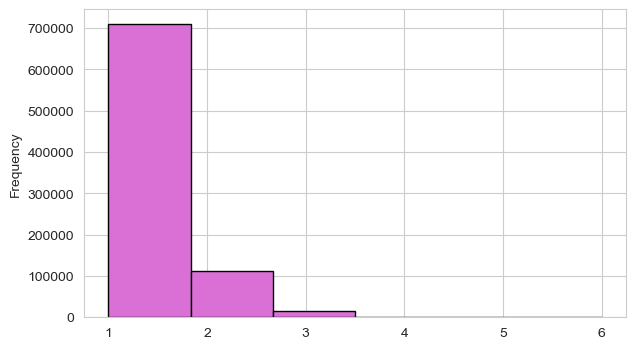

In [536]:
data.groupby('CustomerID').TransactionID.count().plot.hist(bins=6,color='orchid',grid=True,edgecolor='black')

In [537]:
data.head(5)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,1900-01-01 14:27:14,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5


$$2.1 Getting your data + feature   engineering$$

**2) we ask you to group data by the client (using CustomerId) and, based on it, create the following new features for each CustomerID**

In [538]:
#2) #Let's build a function to simplify our work and add series object to our dataframe
def add_col(data,newcolname,col_of_work):
    dictionary=col_of_work.to_dict()
    data[newcolname]=data['CustomerID'].map(dictionary) #to create a column based on CustomerID
    return data.head(3)  


In [539]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,1900-01-01 14:27:14,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5


In [540]:
#code create a new DataFrame grouped by Customer ID 
#data = df.set_index('CustomerID')
#data

In [541]:
#a)Number of Transaction
#Let's extract the Number of Transaction by customer
NumTransaction=data.groupby('CustomerID').TransactionDate.count()


In [542]:
add_col(data,'NumTransaction',NumTransaction)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumTransaction
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1


In [543]:
from currency_converter import CurrencyConverter
from datetime import date
c = CurrencyConverter()
def convert(valueindia):
    dollar=c.convert(valueindia, 'INR', 'USD')
    return dollar
convert(100)

1.2248917459893558

In [544]:
#b) Number of transactions with a balance bigger than 100 USD
#as first let's build a function to convert rupees (INR) in dollars:

data['TransactionAmountUSD']=data['TransactionAmount (INR)'].map(convert).astype(int)

data['TransactionAmountUSD']

0            0
1          342
2            5
3           25
4           21
          ... 
1048562      9
1048563      5
1048564      9
1048565     12
1048566     14
Name: TransactionAmountUSD, Length: 985322, dtype: int32

In [545]:
#and let's converst also the balance for each account in order to have the same unit of currency
data['CustAccountBalanceUSD']=round(data['CustAccountBalance'].map(convert),2)
data['CustAccountBalanceUSD']

0            218.26
1             27.81
2            218.94
3          10613.73
4             82.24
             ...   
1048562       93.52
1048563      334.54
1048564     2716.28
1048565      123.93
1048566      927.66
Name: CustAccountBalanceUSD, Length: 985322, dtype: float64

In [546]:
#b) Number of transactions with a balance bigger than 100 USD

In [547]:
num_t_great100=data[data['TransactionAmountUSD']>100].groupby('CustomerID').TransactionAmountUSD.count()

In [548]:
add_col(data,'Num_Tr_greater_100',num_t_great100)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumTransaction,TransactionAmountUSD,CustAccountBalanceUSD,Num_Tr_greater_100
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,0,218.26,NaN
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,342,27.81,1.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,5,218.94,NaN


In [549]:
data['Num_Tr_greater_100'].isna().sum()

950822

In [550]:
data['Num_Tr_greater_100'].fillna(0,inplace=True)
data['Num_Tr_greater_100'].isna().sum()
data['Num_Tr_greater_100']=data['Num_Tr_greater_100'].astype(int)

In [551]:
#c) Average amount of the transactions
avg=data.groupby('CustomerID').TransactionAmountUSD.mean()
add_col(data,'AVG_Transactions',avg)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumTransaction,TransactionAmountUSD,CustAccountBalanceUSD,Num_Tr_greater_100,AVG_Transactions
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,0,218.26,0,0.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,342,27.81,1,342.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,5,218.94,0,5.0


In [552]:
#d) Average balance
balance=data.groupby('CustomerID').CustAccountBalance.mean()
add_col(data,'AVG_Balance',balance)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumTransaction,TransactionAmountUSD,CustAccountBalanceUSD,Num_Tr_greater_100,AVG_Transactions,AVG_Balance
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,0,218.26,0,0.0,17819.05
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,342,27.81,1,342.0,2270.69
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,5,218.94,0,5.0,17874.44


In [553]:
#e) Average difference between the balance and the transaction amount for each customer 
data['Utilisation']=data['CustAccountBalance']-data['TransactionAmount (INR)']

In [555]:
data['CustGender'].fillna(0,inplace=True)

In [556]:
#f) Most common gender of the customer and add column 'Comm_Gender' to 20 variables of the following question.
#trasform in 0-1
data['CustGender']=np.where(data['CustGender']=='M',0,1)
gender=data.groupby('CustomerID').CustGender.mean()
gender
add_col(data,'Comm_Gender',gender)
data['Comm_Gender']=pd.cut(x=data['Comm_Gender'],bins=[-1,0.49,0.51,2],labels=[0,2,1]) #thanks to pd.cut we can initialize 
#values of the bins and assign to it some labels, the goal is 'categorise' from a continuous variable to a categorical variable
data.head() #the label 'samegender' means that in the specific one CustomerID there are both gender(male and female)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumTransaction,TransactionAmountUSD,CustAccountBalanceUSD,Num_Tr_greater_100,AVG_Transactions,AVG_Balance,Utilisation,Comm_Gender
0,T1,C5841053,1994-10-01,1,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,0,218.26,0,0.0,17819.050,17794.05,1
1,T2,C2142763,1957-04-04,0,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,342,27.81,1,342.0,2270.690,-25728.31,0
2,T3,C4417068,1996-11-26,1,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,5,218.94,0,5.0,17874.440,17415.44,1
3,T4,C5342380,1973-09-14,1,MUMBAI,866503.21,2016-02-08,1900-01-01 14:27:14,2060.0,2,25,10613.73,0,17.5,434849.495,864443.21,2
4,T5,C9031234,1988-03-24,1,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5,1,21,82.24,0,21.0,6714.430,4951.93,1


In [557]:
male=data[data['Comm_Gender']==0].CustGender.count()
female=data[data['Comm_Gender']==1].CustGender.count()
same_gender=data[data['Comm_Gender']==2].CustGender.count()
gender_comm=male,female,same_gender #male are the most common customers of the bank
print('The bank have '+str(female)+' accounts managed by female customers, '+str(male)+' accounts managed by male customers and ' +str(same_gender)+' accounts managed by both gender people... we can assume that they are families or companies')

The bank have 222807 accounts managed by female customers, 670927 accounts managed by male customers and 91588 accounts managed by both gender people... we can assume that they are families or companies


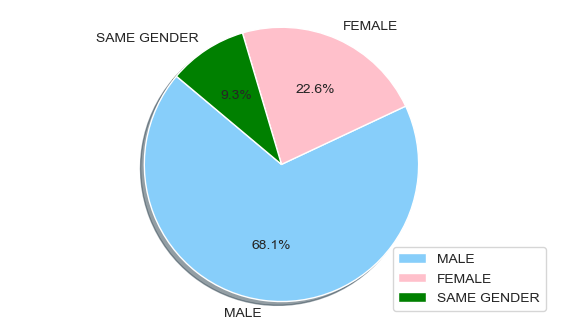

In [558]:
# Plot
labels='MALE','FEMALE','SAME GENDER'
explode = (0, 0,0)
colors = [  'lightskyblue','pink','green']
plt.pie(gender_comm, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.legend( labels, loc='lower right')

plt.axis('equal')
plt.show()

In [559]:
#h) Most frequent location of the customer
data.sort_values(by='TransactionAmountUSD',ascending=False)
data.drop_duplicates(subset='CustomerID',keep='first',inplace=True)

In [560]:
freq_loc_by_maxtrans=data.groupby(['CustomerID','CustLocation']).CustLocation.count()
freq_loc_by_maxtrans=pd.DataFrame(freq_loc_by_maxtrans)
df=freq_loc_by_maxtrans
df
#adesso devi semplicemente mergiare la colonna cust location di stringhe al dataset principale. no concatenate, vedi con merge
#devi mergiare in base al customer id coglione!!!!

,,CustLocation
CustomerID,CustLocation,
C1010011,NOIDA,1
C1010012,MUMBAI,1
C1010014,MUMBAI,1
C1010018,CHAMPARAN,1
C1010024,KOLKATA,1
...,...,...
C9099836,BHIWANDI,1
C9099877,BANGALORE,1
C9099919,GUNTUR,1


In [561]:
comm_df = pd.DataFrame(np.column_stack([df.index.get_level_values('CustLocation').tolist()]))
comm_df.columns = ['CommonLocation']
data['CommonLocation']=comm_df['CommonLocation']
data['CommonLocation'].head(10)

0        NOIDA
1       MUMBAI
2       MUMBAI
3    CHAMPARAN
4      KOLKATA
5        DELHI
6         VAPI
7       MUMBAI
8      GURGAON
9    BANGALORE
Name: CommonLocation, dtype: object

In [562]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumTransaction,TransactionAmountUSD,CustAccountBalanceUSD,Num_Tr_greater_100,AVG_Transactions,AVG_Balance,Utilisation,Comm_Gender,CommonLocation
0,T1,C5841053,1994-10-01,1,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,0,218.26,0,0.0,17819.050,17794.05,1,NOIDA
1,T2,C2142763,1957-04-04,0,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,342,27.81,1,342.0,2270.690,-25728.31,0,MUMBAI
2,T3,C4417068,1996-11-26,1,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,5,218.94,0,5.0,17874.440,17415.44,1,MUMBAI
3,T4,C5342380,1973-09-14,1,MUMBAI,866503.21,2016-02-08,1900-01-01 14:27:14,2060.0,2,25,10613.73,0,17.5,434849.495,864443.21,2,CHAMPARAN
4,T5,C9031234,1988-03-24,1,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5,1,21,82.24,0,21.0,6714.430,4951.93,1,KOLKATA


In [563]:
#Trying to understand better our data...
#Extract the number of different places in the dataset
len(set(data['CustLocation'])) #8164 different places

#What are the places where customers,in general, make more transactions?
loc=data.groupby('CustLocation').NumTransaction.count().reset_index().sort_index()
toplocation=loc.sort_values(by='NumTransaction',ascending=False).head(10)
#top_10_location=toplocation['CustLocation']

In [564]:
toplocation

,CustLocation,NumTransaction
4474,MUMBAI,83276
648,BANGALORE,66285
4902,NEW DELHI,64928
2603,GURGAON,60259
1748,DELHI,57384
4984,NOIDA,26973
1363,CHENNAI,23424
5658,PUNE,20668
2861,HYDERABAD,18637
7061,THANE,17933


In [565]:
#Let's build a function to extract the population size in order to understand the relationship among the number of transactions 
#and the dimension of the city in terms of habitants 
#a lower string (first letter in capital type) is needed in order to perform our query to extract pop. size of the transaction locations
data['CustLocation'].str.lower()
data['CustLocation'] = data['CustLocation'].str.title()

def get_pop_size(city):
    query = """
    SELECT  ?population
    WHERE
    {
      ?city rdfs:label '%s'@en.
      ?city wdt:P1082 ?population.
      ?city wdt:P17 ?country.
      ?city rdfs:label ?cityLabel.
      ?country rdfs:label ?countryLabel.
      FILTER(LANG(?cityLabel) = "en").
      FILTER(LANG(?countryLabel) = "en").
      FILTER(CONTAINS(?countryLabel, "%s")).
    }
    """ % (city,'India')

    res = qwikidata.sparql.return_sparql_query_results(query)
    out = res['results']['bindings'][0]
    populationdict=out
    population = populationdict.get('population')
    
    
    return(population['value'])


In [629]:
#Rtio for Numbai:
ratio_Mumbai= int(toplocation["NumTransaction"].iloc[0])/int(get_pop_size('Mumbai'))*100
ratio_Mumbai #not very loud

0.540252005152622

**3) Consider  at  least  20 additional features that can be generated for each CustomerId**

*INTRODUCTION OF WHAT WE ARE GOING TO DO*

In any finance course of a three-year economics course they explain to you that a bank simply sells products 
(credit cards, deposit accounts, policies, mortgages or loans). Marketing teaches us that knowing one's customers
is an essential step in being able to sell them what they need. From such a dataset like this a bank tries to extract precisely
this information: which customers might be interested in a loan? Which in a pension fund? Which are of child-bearing age?
All this in order to create personalized plans for its customers, especially for the most important ones 
(those who hold the most wealth, which we will now go and find out).

In [642]:
# Let's extract the age of our customer 
data['CAge'] = ((pd.to_datetime('today')-data.CustomerDOB)/np.timedelta64(1,'Y'))
data['CAge'] = data['CAge'].astype(int)
data['CAge']

0          28
1          65
2          26
3          49
4          34
           ..
1048560    42
1048561    30
1048562    32
1048563    30
1048565    44
Name: CAge, Length: 839081, dtype: int32

In [653]:
#1)Age of our customers grouped by Customer Id, taking the mode
age=data.groupby('CustomerID').CAge.agg(pd.Series.mode)
age

839081

In [662]:
add_col(data,'CustomerAge',age)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumTransaction,...,TrDuringWeekend,TransactionDay,TransactionMonth,TransactionHour,TransDayTime,MultiTransactionDay,TransOverBalance,Median_Transaction,CAge,Customerge
0,T1,C5841053,1994-10-01,1,Jamshedpur,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,...,0,Monday,2,14,0,1.0,0.000000,0.0,28,28
1,T2,C2142763,1957-04-04,0,Jhajjar,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,...,0,Monday,2,14,0,1.0,12.297735,342.0,65,65
2,T3,C4417068,1996-11-26,1,Mumbai,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,...,0,Monday,2,14,0,1.0,0.022837,5.0,26,26


Text(0.5, 1.0, 'Distribution of customers Age')

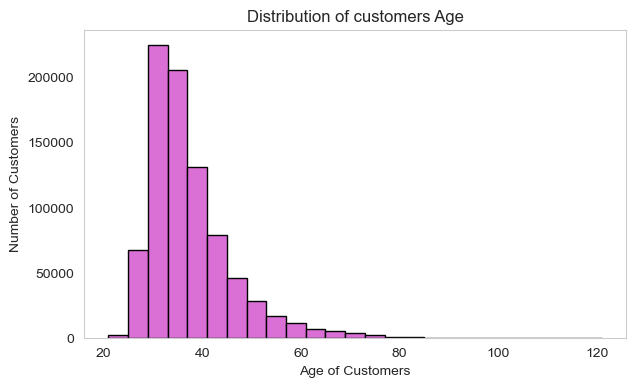

In [663]:
#plot
data.CustomerAge.plot(kind='hist',bins=25,color='orchid',edgecolor='black')
plt.xlabel("Age of Customers")
plt.ylabel('Number of Customers')
plt.title('Distribution of customers Age')

In [664]:
#2) Percentage of customer deposits to the bank's total reserves (we work on USD curreny change in order to have numbers more readable)
total_reserveUSD=data['CustAccountBalanceUSD'].sum()
cust_bal=data.groupby('CustomerID')['CustAccountBalanceUSD'].sum()
cust_bal=pd.DataFrame(cust_bal)
cust_bal
percentage_amount=((cust_bal['CustAccountBalanceUSD'])/(total_reserveUSD))*100
percentage_amount=pd.DataFrame(percentage_amount)
perc_amount=percentage_amount['CustAccountBalanceUSD'].to_numpy()
data['Percentage_Amount']=perc_amount
#data['Percentage_Amount']


In [665]:
total_reserveUSD=round(total_reserveUSD,2)#total reserve of the bank based on the deposit of customers (not the whole reserves of tha bank!)
print(str(total_reserveUSD)+' $') 

1083146691.1 $


In [666]:
set(sorted(round(data['Percentage_Amount'],5),reverse=True)[:55]) #display the customer with the bigger part of bank reserve ... probably those are companys with more Customer Id
#This is important because we can observe that the first four have a very concentrated percentage of wealth in their accounts 
#compared to the rest of the customers. Surely the bank must treat these customers in a special way


{0.04213,
 0.04334,
 0.04787,
 0.04874,
 0.05667,
 0.05767,
 0.06941,
 0.07893,
 0.09301,
 0.13009}

In [686]:
#3) Labels: Let's label customers by balance account: Premium customers, silver and basic. Also young label is useful for customers with age less than 30years.
#Those type of labels are useful for marketing advertising, for instance... Who will be interest on promotion about mortgage?

data1=data.groupby('CustomerID').head()
labels=pd.cut(x=data1['CustAccountBalanceUSD'],bins=[0,100000,1000000,10000000000],labels=['Basic','Silver','Premium'])
labels
#add_col(data,'CustCategory',labels)
#data['CustCategory']
#data1.loc[data['CustAccountBalance']>=100000 ,'CustCategory']='Silver'
#data1.loc[data['CustAccountBalance']>=1000000,'CustCategory']='Premium'
#data1.loc[data['CustAccountBalance']<100000,'CustCategory']='Basic'
#data['CustCategory']=data1['CustCategory']
#we use for this task balance expressed in indian rupee in order to don't have issues with currency change.

0          Basic
1          Basic
2          Basic
3          Basic
4          Basic
           ...  
1048560    Basic
1048561    Basic
1048562    Basic
1048563    Basic
1048565    Basic
Name: CustAccountBalanceUSD, Length: 839081, dtype: category
Categories (3, object): ['Basic' < 'Silver' < 'Premium']

In [583]:
#4) Let's split our customers by age
data['Generation']=pd.cut(x=data.CustomerAge,bins=[0,30,60,120],labels=['Young','Adult','Elderly'])
data['Generation'][:5].unique()

['Young', 'Elderly', 'Adult']
Categories (3, object): ['Young' < 'Adult' < 'Elderly']

In [584]:
#5) Bank Account Solvence: Passive(negative balance) or Active(Positive balance)
data['CustSolvence']=np.where(data['Utilisation']>0,'Active','Passive')

In [585]:
passive=data[data['CustSolvence']=='Passive'].CustSolvence.count()#big part of the customer are insolvent.
print('The bank have '+str(passive)+' passive account')

The bank have 82891 passive account


In [586]:
active=len(data)-passive
percentage_insolvence=(passive/len(data))*100
percentage_insolvence #something near the 10% of the customers have a bank account in red...not a good news for
#the Manager of tha bank! This is a very big ratio.

9.878784050645885

In [587]:
#6) Minimum transaction amount for each customer 
Min_Transaction=data.groupby('CustomerID').TransactionAmountUSD.min()
add_col(data,'Min_Transaction',Min_Transaction)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumTransaction,...,AVG_Balance,Utilisation,Comm_Gender,CommonLocation,CustomerAge,Percentage_Amount,CustCategory,Generation,CustSolvence,Min_Transaction
0,T1,C5841053,1994-10-01,1,Jamshedpur,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,...,17819.05,17794.05,1,NOIDA,28,0.000037,Basic,Young,Active,0
1,T2,C2142763,1957-04-04,0,Jhajjar,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,...,2270.69,-25728.31,0,MUMBAI,65,0.000027,Basic,Elderly,Passive,342
2,T3,C4417068,1996-11-26,1,Mumbai,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,...,17874.44,17415.44,1,MUMBAI,26,0.000043,Basic,Young,Active,5


In [588]:
#7) Maximum transaction amount for each customer 
Max_Transaction=data.groupby('CustomerID').TransactionAmountUSD.max()
add_col(data,'Max_Transaction',Max_Transaction)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumTransaction,...,Utilisation,Comm_Gender,CommonLocation,CustomerAge,Percentage_Amount,CustCategory,Generation,CustSolvence,Min_Transaction,Max_Transaction
0,T1,C5841053,1994-10-01,1,Jamshedpur,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,...,17794.05,1,NOIDA,28,0.000037,Basic,Young,Active,0,0
1,T2,C2142763,1957-04-04,0,Jhajjar,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,...,-25728.31,0,MUMBAI,65,0.000027,Basic,Elderly,Passive,342,342
2,T3,C4417068,1996-11-26,1,Mumbai,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,...,17415.44,1,MUMBAI,26,0.000043,Basic,Young,Active,5,5


In [589]:
#8) Mean of Transaction by Customer
Mean_Transaction=data.groupby('CustomerID').TransactionAmountUSD.mean()
add_col(data,'Mean_Transaction',Mean_Transaction)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumTransaction,...,Comm_Gender,CommonLocation,CustomerAge,Percentage_Amount,CustCategory,Generation,CustSolvence,Min_Transaction,Max_Transaction,Mean_Transaction
0,T1,C5841053,1994-10-01,1,Jamshedpur,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,...,1,NOIDA,28,0.000037,Basic,Young,Active,0,0,0.0
1,T2,C2142763,1957-04-04,0,Jhajjar,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,...,0,MUMBAI,65,0.000027,Basic,Elderly,Passive,342,342,342.0
2,T3,C4417068,1996-11-26,1,Mumbai,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,...,1,MUMBAI,26,0.000043,Basic,Young,Active,5,5,5.0


In [590]:
#9) Quartiles Q1
Q1_Transaction=data.groupby('CustomerID').TransactionAmountUSD.quantile(0.25)
add_col(data,'Q1_Transaction',Q1_Transaction)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumTransaction,...,CommonLocation,CustomerAge,Percentage_Amount,CustCategory,Generation,CustSolvence,Min_Transaction,Max_Transaction,Mean_Transaction,Q1_Transaction
0,T1,C5841053,1994-10-01,1,Jamshedpur,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,...,NOIDA,28,0.000037,Basic,Young,Active,0,0,0.0,0.0
1,T2,C2142763,1957-04-04,0,Jhajjar,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,...,MUMBAI,65,0.000027,Basic,Elderly,Passive,342,342,342.0,342.0
2,T3,C4417068,1996-11-26,1,Mumbai,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,...,MUMBAI,26,0.000043,Basic,Young,Active,5,5,5.0,5.0


In [591]:
#10) Quartiles Q3
Q3_Transaction=data.groupby('CustomerID').TransactionAmountUSD.quantile(0.75)
add_col(data,'Q3_Transaction',Q3_Transaction)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumTransaction,...,CustomerAge,Percentage_Amount,CustCategory,Generation,CustSolvence,Min_Transaction,Max_Transaction,Mean_Transaction,Q1_Transaction,Q3_Transaction
0,T1,C5841053,1994-10-01,1,Jamshedpur,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,...,28,0.000037,Basic,Young,Active,0,0,0.0,0.0,0.0
1,T2,C2142763,1957-04-04,0,Jhajjar,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,...,65,0.000027,Basic,Elderly,Passive,342,342,342.0,342.0,342.0
2,T3,C4417068,1996-11-26,1,Mumbai,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,...,26,0.000043,Basic,Young,Active,5,5,5.0,5.0,5.0


In [592]:
#11) Having a child means big changes (also financial changes), knowing whether 
#a woman is old enough to have children can be useful in creating a customised plan 
data['ChildBearing_Age']='NA'
data.loc[(data['CustomerAge']<=47) & (data['CustGender']==1),'ChildBearing_Age']=1
data.loc[(data['CustGender']==0),'ChildBearing_Age']=0
data.loc[(data['CustomerAge']>47) & (data['CustGender']==1),'ChildBearing_Age']=0
data.head(3)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumTransaction,...,Percentage_Amount,CustCategory,Generation,CustSolvence,Min_Transaction,Max_Transaction,Mean_Transaction,Q1_Transaction,Q3_Transaction,ChildBearing_Age
0,T1,C5841053,1994-10-01,1,Jamshedpur,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,...,0.000037,Basic,Young,Active,0,0,0.0,0.0,0.0,1
1,T2,C2142763,1957-04-04,0,Jhajjar,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,...,0.000027,Basic,Elderly,Passive,342,342,342.0,342.0,342.0,0
2,T3,C4417068,1996-11-26,1,Mumbai,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,...,0.000043,Basic,Young,Active,5,5,5.0,5.0,5.0,1


In [593]:
#12) transaction in a day of the weekend or not 
dtweekend=data.TransactionDate.dt.dayofweek
data['TrDuringWeekend']=np.where(data.TransactionDate.dt.dayofweek>5,1,0)

#13) Transaction during the week:
data.loc[data.TransactionDate.dt.dayofweek==0 ,'TransactionDay']='Monday'
data.loc[data.TransactionDate.dt.dayofweek==1 ,'TransactionDay']='Tuesday'
data.loc[data.TransactionDate.dt.dayofweek==2 ,'TransactionDay']='Wednesday'
data.loc[data.TransactionDate.dt.dayofweek==3 ,'TransactionDay']='Thursday'
data.loc[data.TransactionDate.dt.dayofweek==4 ,'TransactionDay']='Friday'
data.loc[data.TransactionDate.dt.dayofweek==5 ,'TransactionDay']='Saturday'
data.loc[data.TransactionDate.dt.dayofweek==6 ,'TransactionDay']='Sunday'

In [594]:
#14) Transaction in the Month
data['TransactionMonth'] = data['TransactionDate'].dt.month

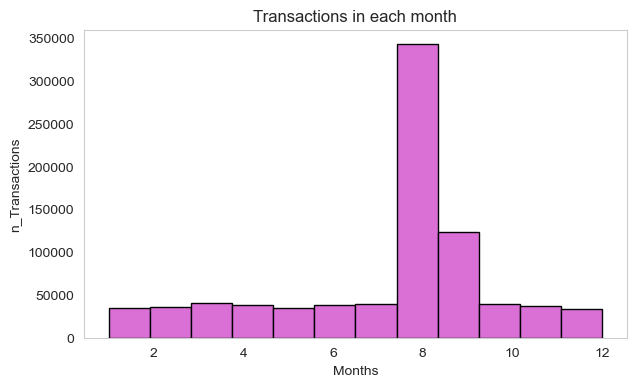

In [595]:
plt.hist(data['TransactionMonth'], color='orchid', edgecolor='black',bins = 12, linewidth=1)
plt.title('Transactions in each month')
plt.xlabel('Months')
plt.ylabel('n_Transactions')
plt.show()
#There is a peak in August, probably due to the period when people ,usually, go on holiday!

In [596]:
#16&17) Transaction hour and in the day: during the day or during the night? [Day Time=1,Night Time=0]
data['TransactionHour'] = data['TransactionTime'].dt.hour
data['TransDayTime']=np.where(data['TransactionHour']>18,1,0)

Text(0.5, 1.0, 'Hour of the Transaction')

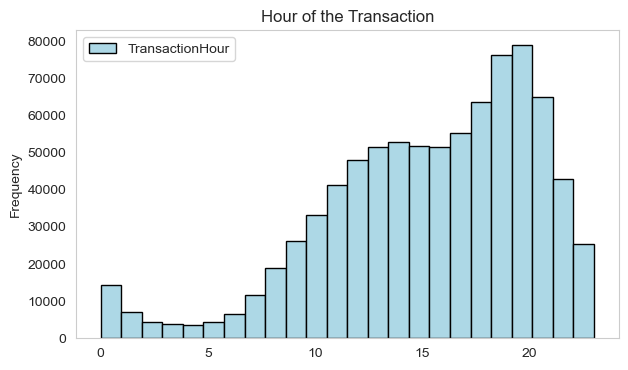

In [597]:
pd.DataFrame(data['TransactionHour']).plot(bins=24,kind='hist',color='lightblue',edgecolor='black')
plt.title('Hour of the Transaction')



Text(0.5, 1.0, 'Period of the day of the Transaction')

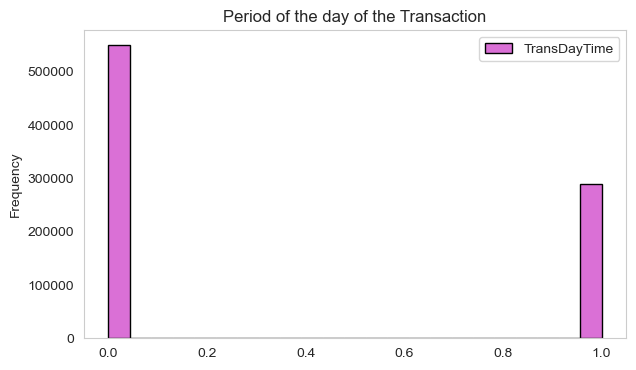

In [598]:
pd.DataFrame(data['TransDayTime']).plot(kind='hist',color='orchid',edgecolor='black',bins=23)
plt.title('Period of the day of the Transaction')
#[Day Time=1,Night Time=0]

In [631]:
#18) #More than one transaction in the same day (Multitransaction in a day)

a=data.groupby(['CustomerID','TransactionDay']).NumTransaction.count().reset_index()
data['MultiTransactionDay']=round(a['NumTransaction'],0)
data['MultiTransactionDay'].fillna(0,inplace=True)
data['MultiTransactionDay']==2
#There are no customers with more than 1 transaction per day

0          False
1          False
2          False
3          False
4          False
           ...  
1048560    False
1048561    False
1048562    False
1048563    False
1048565    False
Name: MultiTransactionDay, Length: 839081, dtype: bool

In [600]:
#19) percentage ratio of amount transaction on whole balance account 
data['TransOverBalance']=(data.TransactionAmountUSD)/(data.CustAccountBalanceUSD)
data['TransOverBalance']
#there are some people that spent more than what they have in account balance

0           0.000000
1          12.297735
2           0.022837
3           0.002355
4           0.255350
             ...    
1048560     6.326889
1048561     1.212121
1048562     0.096236
1048563     0.014946
1048565     0.096829
Name: TransOverBalance, Length: 839081, dtype: float64

In [601]:
#20)Median of Transaction by Customer
median=data.groupby('CustomerID').TransactionAmountUSD.median()
add_col(data,'Median_Transaction',median)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumTransaction,...,Q3_Transaction,ChildBearing_Age,TrDuringWeekend,TransactionDay,TransactionMonth,TransactionHour,TransDayTime,MultiTransactionDay,TransOverBalance,Median_Transaction
0,T1,C5841053,1994-10-01,1,Jamshedpur,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,...,0.0,1,0,Monday,2,14,0,1.0,0.000000,0.0
1,T2,C2142763,1957-04-04,0,Jhajjar,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,...,342.0,0,0,Monday,2,14,0,1.0,12.297735,342.0
2,T3,C4417068,1996-11-26,1,Mumbai,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,...,5.0,1,0,Monday,2,14,0,1.0,0.022837,5.0


In [602]:
#As requested in the readme let's drop the initial variable, in this way we have just a dataset with the variables extracted by us 
data_dropped=data.drop(columns=['TransactionID','CustomerDOB','CustGender','CustLocation','CustAccountBalance','TransactionDate','TransactionTime','TransactionAmount (INR)'])

**2.2 Choose your features (variables)!**

- Normalize the dataset 


In order to reduce the dimensionality of our dataset we can try to use *Pricipal Component Analysis*.
Purpose of *PCA* is to find directions that maximizes the variance. If variance of one variable is higher than others we
make the pca components biased in that direction. So, best thing to do is make the variance of all variables the same.
One way of doing this is by standardizing all the variables.



{Another reason because we need to standardize our data is about unit of measure: A different unit of measure overstress
the other unit in a cluster analysis}

In [603]:
data_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 839081 entries, 0 to 1048565
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   CustomerID             839081 non-null  object  
 1   NumTransaction         839081 non-null  int64   
 2   TransactionAmountUSD   839081 non-null  int32   
 3   CustAccountBalanceUSD  839081 non-null  float64 
 4   Num_Tr_greater_100     839081 non-null  int32   
 5   AVG_Transactions       839081 non-null  float64 
 6   AVG_Balance            839081 non-null  float64 
 7   Utilisation            839081 non-null  float64 
 8   Comm_Gender            839081 non-null  category
 9   CommonLocation         692160 non-null  object  
 10  CustomerAge            839081 non-null  int32   
 11  Percentage_Amount      839081 non-null  float64 
 12  CustCategory           839081 non-null  object  
 13  Generation             838962 non-null  category
 14  CustSolvence       

In [604]:
data_dropped['Comm_Gender']

0          1
1          0
2          1
3          2
4          1
          ..
1048560    0
1048561    0
1048562    0
1048563    0
1048565    0
Name: Comm_Gender, Length: 839081, dtype: category
Categories (3, int64): [0 < 2 < 1]

In [ ]:
dummies = pd.get_dummies(data_dropped['Comm_Gender'],drop_first=False)  
data_drop= pd.concat([data_dropped,dummies],axis=1)
data_drop

In [619]:
data_quant=pd.DataFrame(data_dropped[['Median_Transaction','NumTransaction','TransactionAmountUSD','Num_Tr_greater_100','AVG_Transactions','AVG_Balance','Utilisation','CustomerAge','Min_Transaction','Max_Transaction','Mean_Transaction','Q1_Transaction','Q3_Transaction']])

In [620]:
data_quant

,Median_Transaction,NumTransaction,TransactionAmountUSD,Num_Tr_greater_100,AVG_Transactions,AVG_Balance,Utilisation,CustomerAge,Min_Transaction,Max_Transaction,Mean_Transaction,Q1_Transaction,Q3_Transaction
0,0.0,1,0,0,0.0,17819.050,17794.05,28,0,0,0.0,0.0,0.0
1,342.0,1,342,1,342.0,2270.690,-25728.31,65,342,342,342.0,342.0,342.0
2,5.0,1,5,0,5.0,17874.440,17415.44,26,5,5,5.0,5.0,5.0
3,25.0,2,25,0,17.5,434849.495,864443.21,49,25,25,25.0,25.0,25.0
4,21.0,1,21,0,21.0,6714.430,4951.93,34,21,21,21.0,21.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048560,36.0,1,36,0,36.0,464.870,-2535.13,42,36,36,36.0,36.0,36.0
1048561,18.0,1,18,0,18.0,1212.700,-287.30,30,18,18,18.0,18.0,18.0
1048562,9.0,1,9,0,9.0,7635.190,6836.19,32,9,9,9.0,9.0,9.0
1048563,5.0,1,5,0,5.0,27311.420,26851.42,30,5,5,5.0,5.0,5.0


In [691]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_stand=scaler.fit_transform(data_quant)

In [692]:
data_stand=pd.DataFrame(data_stand)
type(data_stand)

pandas.core.frame.DataFrame

In [693]:
#Let's fit PCA
pca = PCA().fit(data_stand)

In [694]:
#display the percentage of total variance explained by each principal component#
print(pca.explained_variance_ratio_)


[6.35721479e-001 1.51978863e-001 7.80327168e-002 7.43424603e-002
 5.29782100e-002 3.97525093e-003 2.97102012e-003 7.47890213e-033
 3.04973723e-064 1.65331666e-095 2.55846701e-127 4.42069324e-159
 9.83431337e-191]


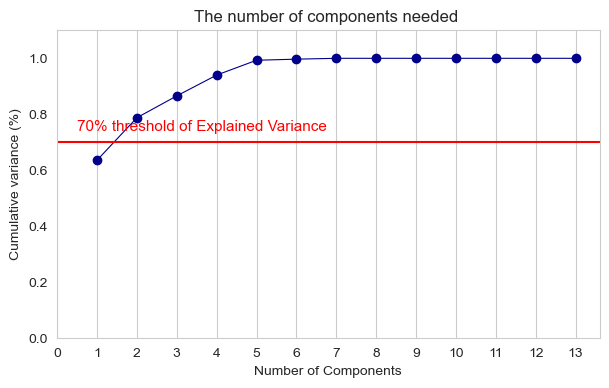

In [695]:
#Let's show how the explained Variance change as Number of components change
plt.rcParams["figure.figsize"] = (7,4)

fig, ax = plt.subplots()
xi = np.arange(1, 14, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='darkblue',linewidth=0.8)

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 14, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed ')

plt.axhline(y=0.70, color='red', linestyle='-',linewidth=1.5)
plt.text(0.5, 0.74, '70% threshold of Explained Variance', color = 'red', fontsize=11)

ax.grid(axis='x')
plt.show()

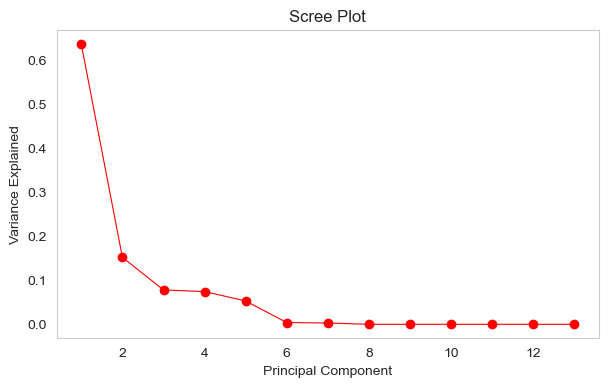

In [696]:
#Scree Plot
PC = np.arange(pca.n_components_) + 1
plt.plot(PC, pca.explained_variance_ratio_, 'o-', linewidth=0.8, color='red')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [703]:
#The two plots above show us that the 'optimal' number of principal component 
pca__ = PCA(n_components=2)
principalComponents = pca__.fit_transform(data_stand)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [738]:
principalDf

,principal component 1,principal component 2
0,-0.712231,-0.279392
1,12.984452,-0.238640
2,-0.540138,-0.322176
3,0.300965,1.147140
4,0.075453,-0.233255
...,...,...
839076,0.655128,-0.133967
839077,-0.051870,-0.305918
839078,-0.368501,-0.244808
839079,-0.521277,-0.237339


In [739]:
principalDf.to_csv('PirncipalDf.csv')

In [705]:
print(pca__.explained_variance_ratio_)

[0.63572148 0.15197886]


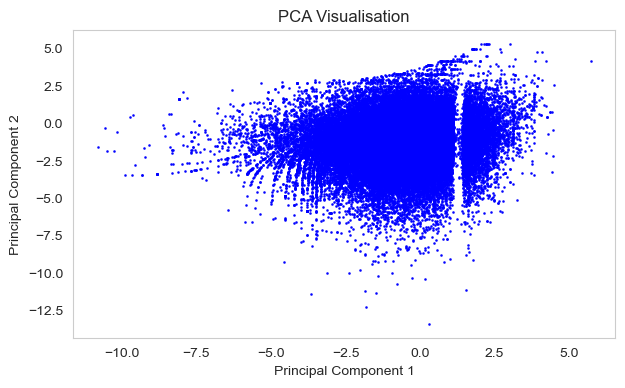

In [723]:
x=np.log(principalDf['principal component 1'])
y=np.log(principalDf['principal component 2'])

plt.scatter(x, y, s=0.8,alpha=.9,color='blue')
plt.title("PCA Visualisation")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [737]:
#let's check the correlation among features
from scipy.stats import pearsonr
pearsonr(principalDf['principal component 1'],principalDf['principal component 2'])
#pvalue too large, no correlation among features. 

PearsonRResult(statistic=9.540979117872439e-17, pvalue=0.9999999992534406)

**2.3 Clustering!**


1) Implement the K-means clustering algorithm (not ++: random initialization). We ask you to write the algorithm from scratch following what you learned in class. !! 
We also ask you to use MapReduce in your K-means algorithm.

In [ ]:
data.to_pickle('bank.pkl') #save in the pickle format
principalDf.to_pickle('principaldata.pkl')

In [ ]:
data = pd.read_pickle('bank.pkl') #and read it ,both 'big' dataset and the pca dataset
principalDf =pd.read_pickle('principaldata.pkl')

$$
d(i, j)=\sqrt{\sum_{k=1}^n\left(x_{i k}-y_{j k}\right)^2}
$$

In [ ]:
def euclidean_distance(point,centroid):
    distance=np.sqrt(np.sum((point - centroid)**2, axis=1))
    return distance

Select the number of cluster is the most problematic stuff in this job. We can just look at the scree plot above and take the 'elbow' of it.

**2.4 Analysing your results!**

You are often encouraged to explain the main characteristics that your clusters have. This is called the Characterizing Clusters step.

In [741]:
data_dropped.set_index('CustomerID')

,NumTransaction,TransactionAmountUSD,CustAccountBalanceUSD,Num_Tr_greater_100,AVG_Transactions,AVG_Balance,Utilisation,Comm_Gender,CommonLocation,CustomerAge,...,Q3_Transaction,ChildBearing_Age,TrDuringWeekend,TransactionDay,TransactionMonth,TransactionHour,TransDayTime,MultiTransactionDay,TransOverBalance,Median_Transaction
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,1,0,218.26,0,0.0,17819.050,17794.05,1,NOIDA,28,...,0.0,1,0,Monday,2,14,0,1.0,0.000000,0.0
C2142763,1,342,27.81,1,342.0,2270.690,-25728.31,0,MUMBAI,65,...,342.0,0,0,Monday,2,14,0,1.0,12.297735,342.0
C4417068,1,5,218.94,0,5.0,17874.440,17415.44,1,MUMBAI,26,...,5.0,1,0,Monday,2,14,0,1.0,0.022837,5.0
C5342380,2,25,10613.73,0,17.5,434849.495,864443.21,2,CHAMPARAN,49,...,25.0,0,0,Monday,2,14,0,1.0,0.002355,25.0
C9031234,1,21,82.24,0,21.0,6714.430,4951.93,1,KOLKATA,34,...,21.0,1,0,Monday,2,18,0,1.0,0.255350,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,1,36,5.69,0,36.0,464.870,-2535.13,0,NaN,42,...,36.0,0,1,Sunday,9,18,0,0.0,6.326889,36.0
C1034220,1,18,14.85,0,18.0,1212.700,-287.30,0,NaN,30,...,18.0,0,1,Sunday,9,18,0,0.0,1.212121,18.0
C8020229,1,9,93.52,0,9.0,7635.190,6836.19,0,NaN,32,...,9.0,0,1,Sunday,9,18,0,0.0,0.096236,9.0


In [ ]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=8)
df_C['cluster'] = model.fit_predict(age_sample)